All data downloaded from [here](https://registry.opendata.aws/noaa-goes/)

Grid mappings that metpy expects to find in attributes somewhere must be one of [these](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#appendix-grid-mappings)

[Super useful GOES image description](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm)

[Beginner's guide to GOES data](https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf)

[GOES AOD Data description](https://www.star.nesdis.noaa.gov/goesr/documents/ATBDs/Baseline/ATBD_GOES-R_Aerosol_Optical_Depth_v4.2_Feb2018.pdf), table 3-22 on page 67 describes the output data
- [all GOES documents](https://www.goes-r.gov/resources/docs.html)

Also, some influence from the repositories from [here](https://github.com/xiaoheyu), which is the basis of [this paper](https://www.mdpi.com/2072-4292/13/23/4788)

[Short GOES-R aerosol training](http://cimss.ssec.wisc.edu/goes/goes-r/training/recordings/Aerosol/presentation_html5.html?lms=1)

[GOES-R reference(?) with a document to calculate SZA and LZA](https://www.ncei.noaa.gov/products/satellite/goes-r-series)

In [1]:
import metpy
import datetime
import rioxarray
import os
import glob
import warnings

import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.colors as colors
import xesmf as xe
import subprocess

from tqdm.notebook import tqdm
from shapely.geometry import mapping
from dask import delayed
from dask.distributed import Client
from pyorbital.orbital import get_observer_look

from matplotlib.colors import LinearSegmentedColormap

xr.set_options(keep_attrs=True)

In [2]:
def day_number_to_date(year, day_number):
    date = pd.to_datetime(year, format='%Y')
    
    return date + pd.to_timedelta(day_number - 1, unit='D') 

# Hourly averages

Parallelizing myself because anytime I use dask I somehow fail to do it properly and it always produces warnings and errors that happen in parallel and most of the tasks always fail

In [3]:
def add_lat_lon(ds, proj):
    xs, ys = np.meshgrid(ds.x, ds.y)
    transformed = ccrs.PlateCarree().transform_points(src_crs=proj, x=xs, y=ys)
    ds = ds.assign_coords({
            "lat":(["y","x"],transformed[:,:,1]),
            "lon":(["y","x"],transformed[:,:,0])
        })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    
    return ds

def listdir(path):
    for item in os.listdir(path):
        if item.startswith('.'):
            # ignore hidden files
            continue
        else:
            yield item
            
def get_projection(ds, variable):
    dat = ds.metpy.parse_cf(variable)
    return dat, dat.metpy.cartopy_crs
    
def convert_to_geostationary(ds, variable):
    dat = ds.metpy.parse_cf(variable)
    proj = dat.metpy.cartopy_crs
    
    x = dat.x
    y = dat.y
    
    sat_h = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign_coords(x=ds.x * sat_h, y=ds.y * sat_h)
    
    ds.x.attrs = {'units': 'm',
     'axis': 'X',
     'long_name': 'X sweep in crs',
    }
    ds.y.attrs = {'units': 'm',
     'axis': 'Y',
     'long_name': 'Y sweep in crs',
    }

    return ds, proj

In [4]:
# dates = pd.date_range('05/24/2017', '10/22/2022', freq='1h')
dates = pd.date_range(day_number_to_date(2018, 336), day_number_to_date(2022, 288), freq='1h')

In [ ]:
chunk_size = 6
grouped_timestamps = [dates[i:i + chunk_size] for i in range(0, len(dates), chunk_size)]
pbar = tqdm(grouped_timestamps)
for hours in pbar:
    pbar.set_description(' | '.join([f'{hour.year} {hour.day_of_year} {hour.hour:02}' for hour in hours]))
    procs = [subprocess.Popen(['python', 'hour_average.py', hour.strftime('%m/%d/%y %H:%M')]) for hour in hours]
    for p in procs:
        p.wait()

In [79]:
from pickle import load
with open('/Volumes/Canon/averages/hourly/2018/320/18-errors.pcl', 'rb') as handle:
    result = load(handle)


# Daily Average

In [32]:
dates = pd.date_range('05/24/2017', day_number_to_date(2022, 288), freq='1d')

In [ ]:
pbar = tqdm(dates)
for day in pbar:
    pbar.set_description(f'{day.year} {day.day_of_year}')
    daily_average(day)

In [3]:
daily_average(pd.to_datetime('2021-07-26'))

In [2]:
def daily_average(
        date,
        save_path = '/Volumes/Canon/averages/daily'
    ):
    year = os.path.join(save_path, f'{date.year}')
    os.makedirs(year, exist_ok=True)
    path = os.path.join(year, f'{date.day_of_year:03}.nc')
    if os.path.exists(path):
        return
    
    try:
        ds = xr.open_mfdataset(
            f'/Volumes/Canon/averages/hourly/{date.year}/{date.day_of_year:03}/*.nc',
            concat_dim="t",
            parallel=True,
            combine='nested',
            data_vars='different',
        )
    except:
        return

    shape = ds.y.size, ds.x.size

    # weighted average
    # https://math.stackexchange.com/questions/2091521/how-do-i-calculate-a-weighted-average-from-two-averages
    # find the total number of snapshots used in a cell over the 24 hour period
    total = ds.n_snapshots.sum('t').compute()
    # the sum places zeros where nans were, replace those zeros with nans
    # so that we know which grid cells never had data
    total = xr.where(total == 0, np.nan, total)

    # AOD 550nm average
    weights = (ds.n_snapshots / total).compute().data
    weighted = weights * ds.AOD.data.compute()
    avg = np.nansum(weighted, axis=0)
    avg = xr.where(total.isnull(), np.nan, avg).data

    # AOD 470nm average if it exists
    avg470 = np.full(shape, np.nan)
    ae = np.full(shape, np.nan)
    aod470_attrs = {}

    if 'AOD470' in ds:
        aod470_attrs = ds.AOD470.attrs
        # this one shows us were aod470 was not null at least once in all cells. not sure
        # how to do this by hand
        a = ds.AOD470.resample(t='1d').mean()
        snaps = ds.n_snapshots.copy()
        snaps = xr.where(ds['AOD470'].isnull(), np.nan, snaps)

        aod470_total = snaps.sum('t').compute()
        aod470_total = xr.where(aod470_total == 0, np.nan, aod470_total)
        aod470_weights = (snaps / aod470_total).compute().data

        weighted = aod470_weights * ds.AOD470.data.compute()
        avg470 = np.nansum(weighted, axis=0)
        avg470 = xr.where(a.isnull(), np.nan, avg470).data.compute()
        ae = (- np.log(avg470 / avg) / np.log(470/550))

    # create the dataset
    time = [pd.to_datetime(ds.t.resample(t='1d').mean().item())]
    coord_order = ['time', 'y', 'x']
    shape = (1, *shape)

    ae1_attrs = {'long_name': 'Angstrom Exponent corresponding to 0.47 / 0.86 micron wavelength pair',
     'valid_range': [0, 65530],
     'grid_mapping': 'goes_imager_projection'}

    data_vars = {
        'AOD':        ( coord_order, avg.reshape(shape), ds.AOD.attrs ),
        'AOD470':     ( coord_order, avg470.reshape(shape).astype(np.float32)  , aod470_attrs ),
        'AE':         ( coord_order, ae.reshape(shape).astype(np.float32)  , ae1_attrs ),
        'n_snapshots':( coord_order, total.data.reshape(shape), ds.n_snapshots.attrs ),
        'goes_imager_projection': ([], 0, ds.goes_imager_projection.attrs)
    }

    # define coordinates
    coords = {
        'time': (['time'], time),
        'y': (['y'], ds.y.data, ds.y.attrs),
        'x': (['x'], ds.x.data, ds.x.attrs)
    }

    # define global attributes
    attrs = {}

    # create dataset
    ds1 = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)
    ds1.to_netcdf(path)

# Some maps

In [36]:
with xr.open_dataset('/Volumes/Canon/averages/daily/2021/236.nc') as ds:
    ds.load()

In [37]:
proj = ds.metpy.parse_cf('AOD').metpy.cartopy_crs

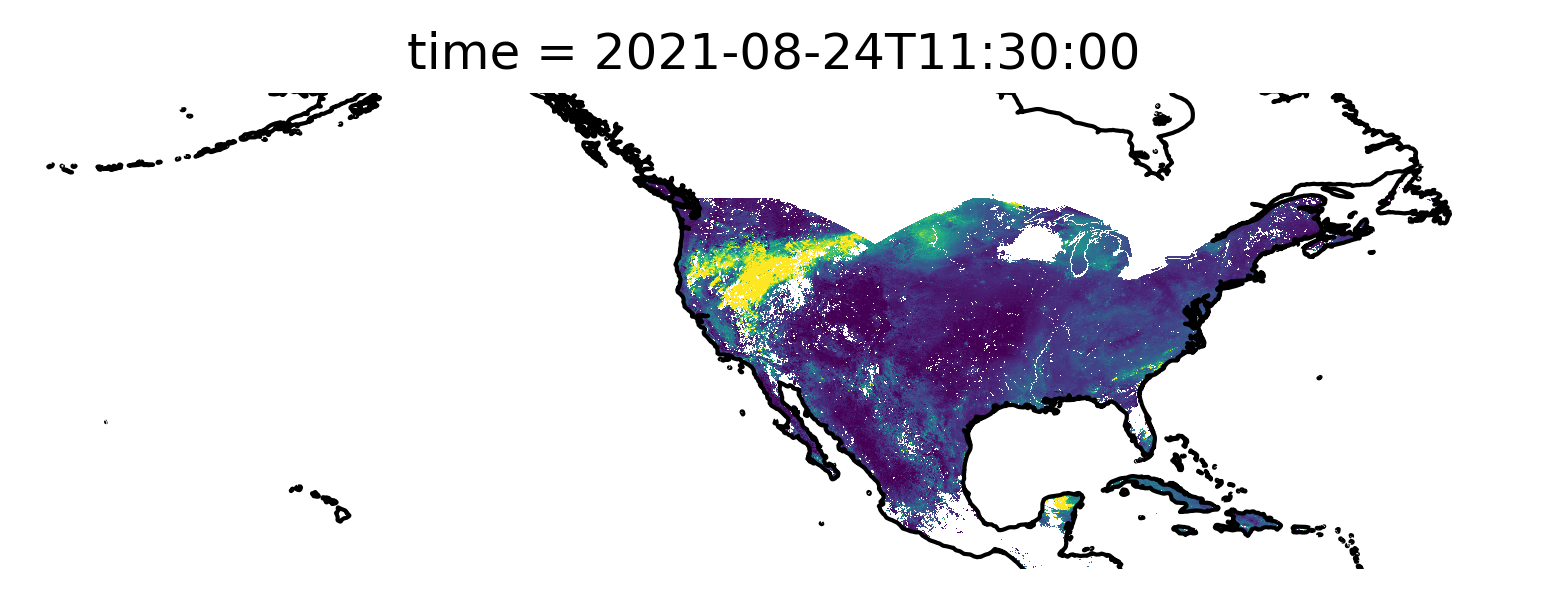

In [38]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.AOD.plot(ax=ax, transform=proj, vmin=0, vmax=1, add_colorbar=False, cmap='viridis')

ax.coastlines()
ax.spines[:].set_visible(False)
ax.set_extent((-109.44988774254873, 28.658281065059967, 14.561802456952117, 58.7685727390221), ccrs.PlateCarree(central_longitude=-75))

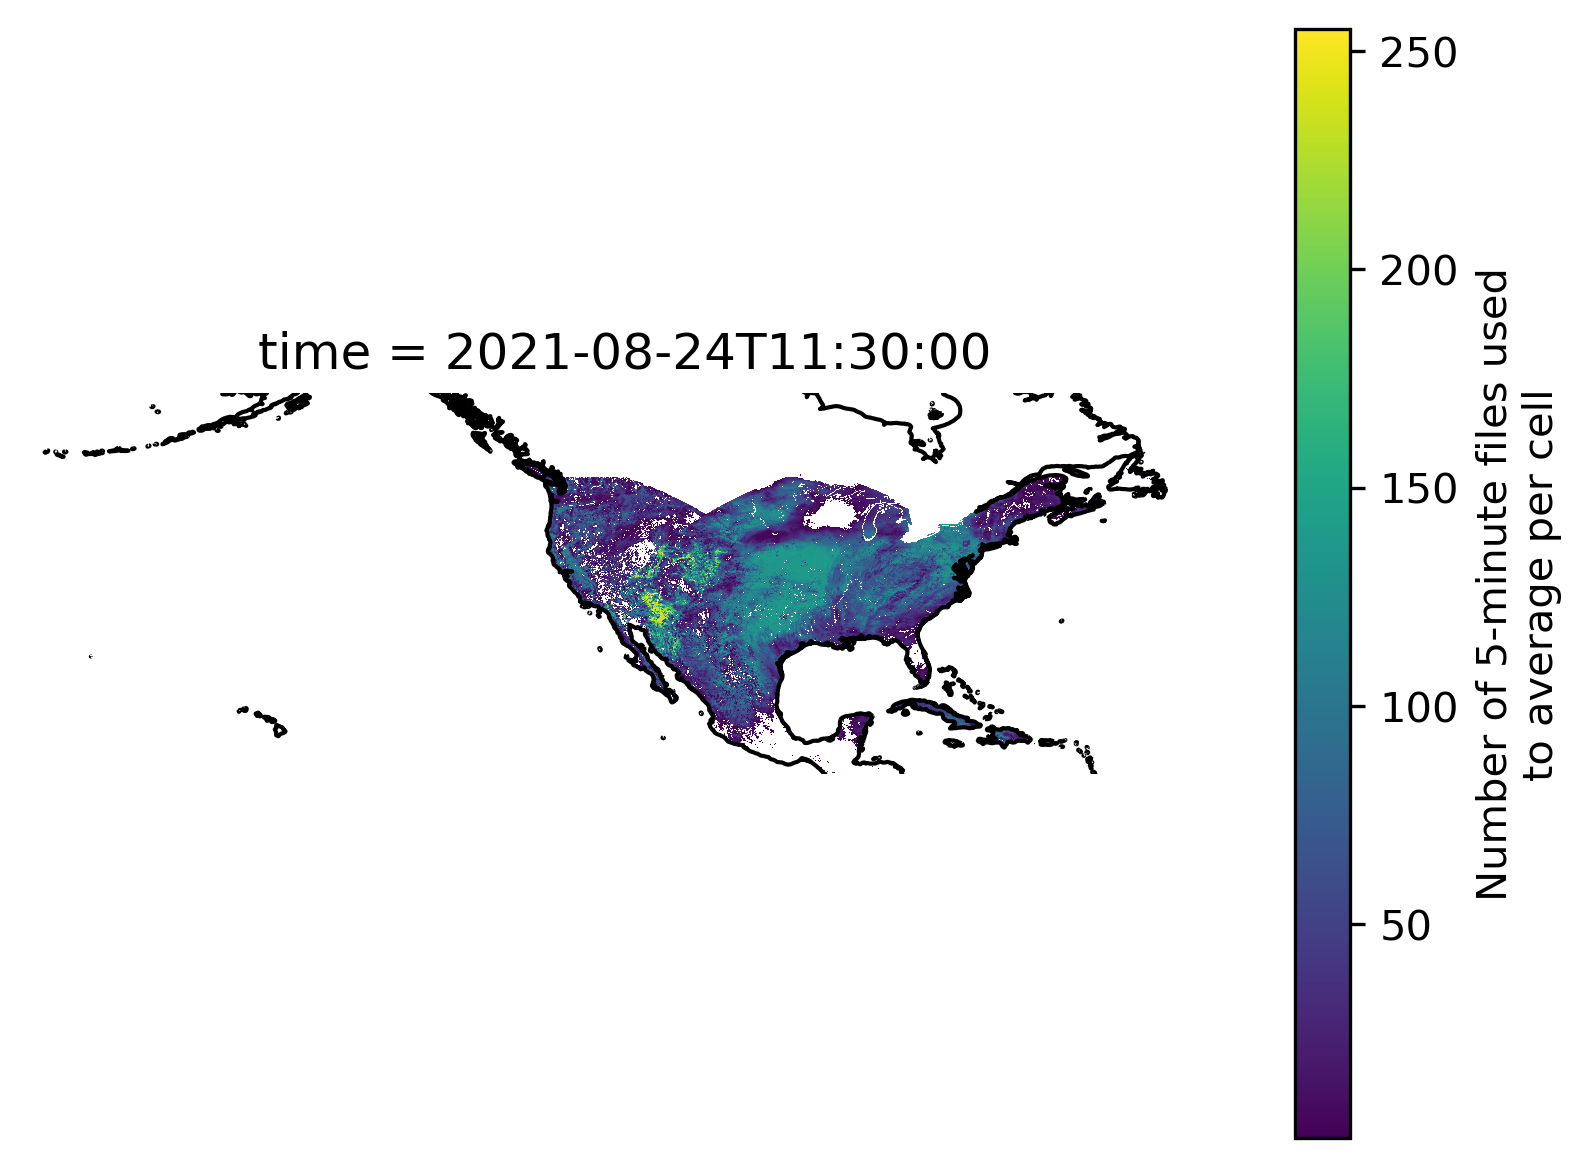

In [39]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.n_snapshots.plot(ax=ax, transform=proj)

ax.coastlines()
ax.spines[:].set_visible(False)
ax.set_extent((-109.44988774254873, 28.658281065059967, 14.561802456952117, 58.7685727390221), ccrs.PlateCarree(central_longitude=-75))

In [40]:
for i in ds.coords:
    print(i, ds[i].nbytes / 1e6)
    
for i in ds.data_vars:
    print(i, ds[i].nbytes / 1e6)

time 8e-06
y 0.012
x 0.019792
AOD 14.844
AOD470 14.844
AE 14.844
n_snapshots 14.844
goes_imager_projection 8e-06


In [41]:
ds

<xarray.Dataset>
Dimensions:                 (time: 1, y: 1500, x: 2474)
Coordinates:
  * time                    (time) datetime64[ns] 2021-08-24T11:30:00
  * y                       (y) float64 4.588e+06 4.586e+06 ... 1.584e+06
  * x                       (x) float64 -3.574e+06 -3.572e+06 ... 1.382e+06
Data variables:
    AOD                     (time, y, x) float32 nan nan nan nan ... nan nan nan
    AOD470                  (time, y, x) float32 nan nan nan nan ... nan nan nan
    AE                      (time, y, x) float32 nan nan nan nan ... nan nan nan
    n_snapshots             (time, y, x) float32 nan nan nan nan ... nan nan nan
    goes_imager_projection  int64 0